In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statsmodels.api as sm
from scipy.special import gamma, loggamma, factorial
import scipy.stats
from scipy.interpolate import interp1d
from matplotlib.ticker import AutoMinorLocator 
from matplotlib import rc, font_manager
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors
from mycolorpy import colorlist as mcp
from matplotlib import legend_handler
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import collections
import matplotlib
import shapely.geometry
import shapely.ops 
from geopy.geocoders import Nominatim
import geopandas as gpd
import mapclassify
import jenkspy
import contextily as cx
import os
import rioxarray as rx
import pyreadr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import plots
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
wd = os.path.dirname(os.getcwd())

In [4]:
country = "ARG"

if country == "ARG":
    country_full = "argentina"
elif country == "CHL":
    country_full = "chile"
elif country == "COL":
    country_full = "colombia"
elif country == "MEX":
    country_full = "mexico"

In [5]:
gdf = gpd.read_file(wd + '/data/outputs/' + country + '/gdf_' + country + '_admin_fua_rdi.gpkg').to_crs('epsg:4326')



In [6]:
len(gdf)

163

In [ ]:
evo_admins_crisis = []
evo_admins_baseline = []
evo_admins_perchange = []

months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
years = ['2020', '2021', '2022']

gdf_admin_mov = gdf

for year in years:
    for month in months:
        print(month, year)
        try:
            df_mov = pyreadr.read_r('/Volumes/RECAST/data/outputs/' + country_full + '/movements/' + str(year) + '_' + str(month) + '_mov.rds')
            df_mov = df_mov[None]
            df_mov = df_mov[df_mov['length_km'] > 0].reset_index(drop=True)
            df_mov = df_mov[df_mov['length_km'] < 70].reset_index(drop=True)
            df_mov['geometry'] = df_mov['geometry'].apply(shapely.wkt.loads)
            gdf_mov = gpd.GeoDataFrame(df_mov, crs='epsg:4326')
        except:
            print('no')
            continue
            
        gdf_mov_join = gdf_mov
        gdf_admin_mov_join = gdf.sjoin(gdf_mov_join, how="left", predicate='intersects')

        gdf_admin_mov_join['index'] = gdf_admin_mov_join.index

        gdf_group = gdf_admin_mov_join.groupby(['index']).sum().reset_index(drop=True)

        gdf_admin_mov['n_crisis_' + str(month) + '_' + str(year)] = gdf_group['n_crisis']
        gdf_admin_mov['n_baseline_' + str(month) + '_' + str(year)] = gdf_group['n_baseline']
        gdf_admin_mov['n_perchange_' + str(month) + '_' + str(year)] = (gdf_group['n_crisis']-gdf_group['n_baseline'])/gdf_group['n_baseline']*100

for year in years:
    for month in months:  
        try:
            gdf_admin_mov = gdf_admin_mov[gdf_admin_mov['n_baseline_' + str(month) + '_' + str(year)] != 0].reset_index(drop=True)
        except:
            continue
            
for year in years:
    for month in months:  
        try: 
            gdf_admin_mov['z_score_crisis_' + str(month) + '_' + str(year)] = np.abs(scipy.stats.zscore(gdf_admin_mov['n_crisis_' + str(month) + '_' + str(year)]))
            gdf_admin_mov['z_score_baseline_' + str(month) + '_' + str(year)] = np.abs(scipy.stats.zscore(gdf_admin_mov['n_baseline_' + str(month) + '_' + str(year)]))
            gdf_admin_mov['z_score_perchange_' + str(month) + '_' + str(year)] = np.abs(scipy.stats.zscore(gdf_admin_mov['n_perchange_' + str(month) + '_' + str(year)]))
        except:
            continue
            
gdf_admin_mov.to_file(wd + '/data/outputs/' + country + '/gdf_' + country + '_admin_rdi_mov_evo.gpkg')
            

In [ ]:
country = "MEX"

if country == "ARG":
    country_full = "argentina"
elif country == "CHL":
    country_full = "chile"
elif country == "COL":
    country_full = "colombia"
elif country == "MEX":
    country_full = "mexico"

In [7]:
gdf_admin_mov = gpd.read_file(wd + '/data/outputs/' + country + '/gdf_' + country + '_admin_rdi_mov_evo.gpkg')

months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
years = ['2020', '2021', '2022']

for year in years:
    for month in months:  
        try:
            gdf_admin_mov = gdf_admin_mov[gdf_admin_mov['z_score_perchange_' + str(month) + '_' + str(year)] < 4].reset_index(drop=True)
        except:
            continue

    
evo_admins = []
for i in range(len(gdf_admin_mov)):
    evo_admin = []
    for year in years:
        for month in months:
            try:
                evo_admin.append(gdf_admin_mov.loc[i, 'n_perchange_' + month + '_' + year])
            except:
                continue
    evo_admins.append(evo_admin)
    

In [8]:
df_stringency = pd.read_csv("/Volumes/RECAST/data/covid_stringency/owid-covid-data.csv")
df_stringency = df_stringency[df_stringency['location'] == str(country_full).capitalize()].reset_index(drop=True)
df_stringency = df_stringency.filter(['location', 'date', 'stringency_index'], axis=1)
df_stringency = df_stringency.fillna(0)
df_stringency['monthyear'] = [str(date)[0:7] for date in df_stringency['date']]
monthyears = np.unique(df_stringency['monthyear'])

stringencies = []
for monthyear in monthyears:
    df_stringency_monthyear = df_stringency[df_stringency['monthyear']==monthyear].reset_index(drop=True)
    stringencies.append(np.mean(df_stringency_monthyear['stringency_index']))
    
monthyears = monthyears[3:-10]
stringencies = stringencies[3:-10]

print(monthyears)

['2020-04' '2020-05' '2020-06' '2020-07' '2020-08' '2020-09' '2020-10'
 '2020-11' '2020-12' '2021-01' '2021-02' '2021-03' '2021-04' '2021-05'
 '2021-06' '2021-07' '2021-08' '2021-09' '2021-10' '2021-11' '2021-12'
 '2022-01' '2022-02' '2022-03' '2022-04' '2022-05']


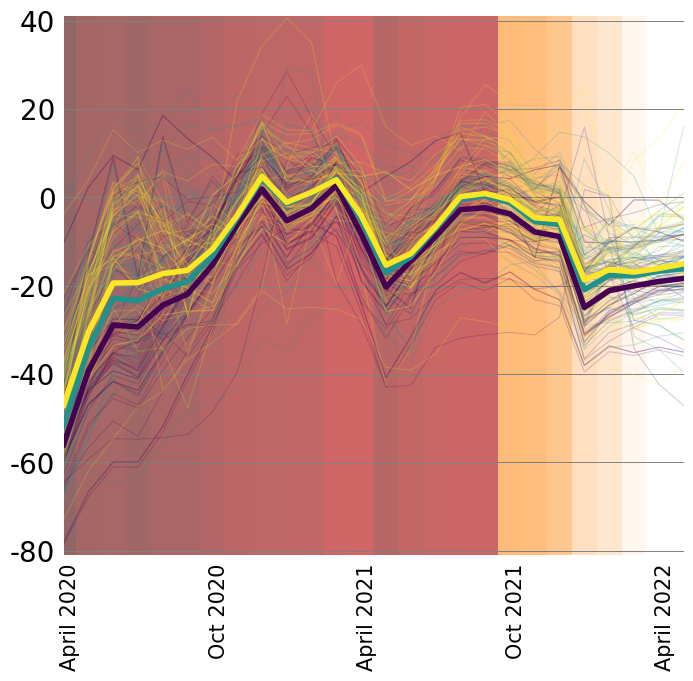

In [9]:
fig,ax = plt.subplots(figsize=(8,7))

ax.spines['bottom'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.spines['left'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=20, pad=9)

gdf_admin_mov = gdf_admin_mov.sort_values(by = ['rdi'], ascending=True).reset_index(drop=True)

n_clusters = 3
gdf_admin_mov['percentile'] = pd.qcut(gdf_admin_mov['rdi'], q=n_clusters, labels=[i+1 for i in range(n_clusters)])

evo_averages = []
evo_clusters = []
for i in range(n_clusters):
    gdf_admin_mov_cl = gdf_admin_mov[gdf_admin_mov['percentile']==i+1].reset_index(drop=True)
    for j in range(len(gdf_admin_mov_cl)):
        evo_cluster = []
        for year in years:
            for month in months:
                try:
                    evo_cluster.append(gdf_admin_mov_cl.loc[j, 'n_perchange_' + month + '_' + year])
                except:
                    continue
        evo_clusters.append(evo_cluster)
    evo_averages.append(np.mean(np.array(evo_clusters), axis=0))



viridis = plt.cm.get_cmap('viridis')
norm = plt.Normalize(min(gdf_admin_mov['percentile']), max(gdf_admin_mov['percentile']))

for i in range(len(gdf_admin_mov)):
    color = viridis(norm(gdf_admin_mov.loc[i, 'percentile']))  
    ax.plot(np.arange(len(evo_admins[i])), evo_admins[i], color=color, alpha=0.2, lw=0.8)
    
for i in range(n_clusters):
    color = viridis(norm(i+1)) 
    ax.plot(np.arange(len(evo_averages[i])), evo_averages[i], color=color, zorder=100, lw=4)
    
for k in range(len(evo_averages[0])):
    try:
        rgba = matplotlib.cm.gist_heat(1-(stringencies[k]-min(stringencies))/max(stringencies))
    except:
        rgba = matplotlib.cm.gist_heat(1-(stringencies[k-1]-min(stringencies))/max(stringencies))
    x = [k-.50, k+.50]
    ax.fill_between(x, 100*np.ones(len(x)), -100*np.ones(len(x)), color=rgba, alpha=0.6, edgecolor='None', linewidth=0, zorder=0)

xmin, xmax = 0,25
ax.set_xlim([xmin, xmax])

xticks = []
xticks_labels = ['April 2020', 'Oct 2020', 'April 2021', 'Oct 2021', 'April 2022']
for i in range(int(xmin), int(xmax)):
    if i%6 == 0:
        xticks.append(i+.25)
ax.set_xticks(xticks, xticks_labels)
ax.tick_params(axis = 'x', bottom=True, labelsize = 15, pad=6, rotation=90)
    
ymin, ymax = -81, 41
ax.set_ylim([ymin, ymax])

yticks = []
for i in range(int(ymin), int(ymax)):
    if i%20 == 0:
        yticks.append(i)
ax.set_yticks(yticks, yticks)
for y in yticks:
    ax.plot([xmin, xmax],[y,y], color='gray', lw=0.7, zorder=0)
ax.tick_params(axis = 'y', labelsize = 20, pad=6, rotation=0)

# plt.savefig(wd + '/plots/country_' + country + '/' + country + '_evo_perchange_admin_rdi.pdf', bbox_inches = 'tight')

plt.show()

In [ ]:
cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh))
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} colormaps', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=matplotlib.colormaps[name], alpha=0.7)
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list

plot_color_gradients('',
                     ['viridis'])
